<a href="https://colab.research.google.com/github/petersun1937/sarcasm_detection/blob/main/Sarcasm_Detection_with_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy pandas tensorflow keras matplotlib seaborn nltk swifter gensim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 16.9 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=63205571ac8246dd58f899bfc6994a0de45e49bf8fdf8a95d0b6ddcaf067d8cb
  Stored in directory: /root/.cache/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built swifter


In [66]:
import pandas as pd

# Load train dataset
train_path = "train.csv"  # Update path if needed
test_path = "test.csv"    # Update path if needed

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Display first few rows
print("Train Dataset Sample:")
print(df_train.head())

print("\nTest Dataset Sample:")
print(df_test.head())

# Check data distribution
print("\nClass Distribution in Train Set:")
print(df_train['class'].value_counts())

print("\nClass Distribution in Test Set:")
print(df_test['class'].value_counts())

Train Dataset Sample:
                                              tweets       class
0  Be aware  dirty step to get money  #staylight ...  figurative
1  #sarcasm for #people who don't understand #diy...  figurative
2  @IminworkJeremy @medsingle #DailyMail readers ...  figurative
3  @wilw Why do I get the feeling you like games?...  figurative
4  -@TeacherArthurG @rweingarten You probably jus...  figurative

Test Dataset Sample:
                                              tweets       class
0  no one ever predicted this was going to happen...  figurative
1  @Stooshie its as closely related as Andrews or...  figurative
2  I find it ironic when Vegans say they love foo...  figurative
3  Quick rt that throwing money vine I've not see...  figurative
4  yep, keep adding me to your #devops lists.... ...  figurative

Class Distribution in Train Set:
class
figurative    21238
irony         20894
sarcasm       20681
regular       18595
Name: count, dtype: int64

Class Distribution in Test Se

In [67]:
import re
import pandas as pd
import swifter

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"https?://\S+|www\.\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#(irony|sarcasm|sarcastic|ironic)\b", "", text)  # Remove #irony/ironic and #sarcasm/sarcastic
    #text = re.sub(r"[^a-zA-Z0-9'!?]", " ", text)  # Keep only relevant characters
    text = re.sub(r"[^a-zA-Z0-9#'!?]", " ", text)  # Keep only relevant characters
    return " ".join(text.split())  # Remove extra spaces


# Apply cleaning with Swifter (parallelized)
df_train['cleaned_tweet'] = df_train['tweets'].swifter.apply(clean_text)
df_test['cleaned_tweet'] = df_test['tweets'].swifter.apply(clean_text)

# Debug print: Check if URLs are gone
print(df_train["cleaned_tweet"].sample(10))


Pandas Apply:   0%|          | 0/81408 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8128 [00:00<?, ?it/s]

41363    i just realized that i spent my last day of su...
47156    life is too short to be working being around p...
80936                      wow what a star studded lineup!
38838    i'm watching 'blade runner' via on my #nexus 1...
59190    android design #android #education #design #te...
19451    weird thing is i realize the initial post is a...
38269    in case your #lamestreammedia forgot to inform...
4214     tip if you are doing a kickstarter vid about v...
11716    nothing makes your shift more enjoyable than c...
34103    this is what abbott said when in opposition if...
Name: cleaned_tweet, dtype: object


In [68]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Drop rows with NaN in the 'class' column
df_train = df_train.dropna(subset=['class'])
df_test = df_test.dropna(subset=['class'])

# Tokenize
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['cleaned_tweet'])

train_sequences = tokenizer.texts_to_sequences(df_train['cleaned_tweet'])
test_sequences = tokenizer.texts_to_sequences(df_test['cleaned_tweet'])

# Pad sequences
max_length = max(len(seq) for seq in train_sequences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post")

## Ensure train and test datasets have the same classes
common_classes = set(df_train['class']).intersection(set(df_test['class']))
df_test = df_test[df_test['class'].isin(common_classes)]

# Label Encoding (Single call)
label_encoder = LabelEncoder()
df_train['encoded_class'] = label_encoder.fit_transform(df_train['class'])
df_test['encoded_class'] = label_encoder.transform(df_test['class'])

# Convert labels to Numpy arrays
train_labels = np.array(df_train['encoded_class'])
test_labels = np.array(df_test['encoded_class'])

# Ensure no mismatch
assert train_padded.shape[0] == train_labels.shape[0], "train_padded and train_labels mismatch"


In [69]:
# Split train into train and val
train_padded, val_padded, train_labels, val_labels = train_test_split(
    train_padded, train_labels, test_size=0.2, stratify=train_labels, shuffle=True
)

# Shuffle
train_padded, train_labels = shuffle(train_padded, train_labels)

print("\nClass Distribution in Training Set:\n", pd.Series(train_labels).value_counts(normalize=True))
print("\nClass Distribution in Validation Set:\n", pd.Series(val_labels).value_counts(normalize=True))
print("\nClass Distribution in Test Set:\n", pd.Series(test_labels).value_counts(normalize=True))


Class Distribution in Training Set:
 0    0.260879
1    0.256656
3    0.254046
2    0.228419
Name: proportion, dtype: float64

Class Distribution in Validation Set:
 0    0.260902
1    0.256664
3    0.254023
2    0.228412
Name: proportion, dtype: float64

Class Distribution in Test Set:
 1    0.260007
3    0.259268
0    0.251755
2    0.228969
Name: proportion, dtype: float64


In [74]:
import gensim.downloader as api
import numpy as np

# Load GloVe 50D from gensim
glove_model = api.load("glove-wiki-gigaword-50")
embedding_dim = 50  # GloVe 50D

# Initialize embedding matrix
embedding_matrix = np.zeros((5000, embedding_dim))

# Fill embedding matrix with GloVe vectors
for word, index in tokenizer.word_index.items():
    if index < 5000:
        if word in glove_model:
            embedding_matrix[index] = glove_model[word]

In [ ]:
import gensim.downloader as api
import numpy as np

# Load Pretrained Word2Vec (Google News 300D)
word2vec_model = api.load("word2vec-google-news-300")
embedding_dim = 300  # Word2Vec uses 300 dimensions

# Initialize embedding matrix
embedding_matrix = np.zeros((5000, embedding_dim))

# Fill embedding matrix with Word2Vec vectors
for word, index in tokenizer.word_index.items():
    if index < 5000:
        if word in word2vec_model:
            embedding_matrix[index] = word2vec_model[word]


In [75]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, Bidirectional, BatchNormalization, LayerNormalization, RNN, LSTMCell
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Define model

# Use pretrained embeddings
# Bidirectional single LSTM layer
model = Sequential([
    Embedding(input_dim=5000, output_dim=50, weights=[embedding_matrix], input_length=max_length, trainable=True),

    Bidirectional(LSTM(128, return_sequences=False, dropout=0.5)),  # Single LSTM layer, outputting final sequence
    BatchNormalization(),  # Helps stabilize training

    Dense(32, activation='relu'),
    Dropout(0.5),

    Dense(4, activation='softmax')  # Output layer
])

# Bidirectional 2 LSTM layers
'''model = Sequential([
    Embedding(input_dim=5000, output_dim=50, weights=[embedding_matrix], input_length=max_length, trainable=True),
    #Embedding(input_dim=5000, output_dim=300, weights=[embedding_matrix], input_length=max_length, trainable=True),  # Word embeddings
    Bidirectional(LSTM(256, return_sequences=True, dropout=0.5)),
    BatchNormalization(),  # Stabilizes training
    Bidirectional(LSTM(128, return_sequences=False, dropout=0.5)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])'''


# CNN with LSTM
'''model = Sequential([
    Embedding(input_dim=5000, output_dim=50, weights=[embedding_matrix], input_length=max_length, trainable=True),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(64),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 output classes
])'''

# Self trained emb with 2 LSTMs
'''model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_length),  # Word embeddings
    LSTM(128, return_sequences=True),  # First LSTM layer with return_sequences=True
    BatchNormalization(),  # Stabilizes training
    LSTM(64),  # Second LSTM layer
    Dense(64, activation='relu'),  # Fully connected layer
    Dropout(0.5),  # Dropout for regularization
    Dense(4, activation='softmax')  # Output layer with softmax activation for 4 classes
])'''

# Self trained emb with 2 BiLSTMs
'''model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_length),  # Word embeddings

    Bidirectional(LSTM(256, return_sequences=True, dropout=0.5)),

    BatchNormalization(),  # Stabilizes training

    Bidirectional(LSTM(128, return_sequences=False, dropout=0.5)),

    Dense(32, activation='relu'),  # Fully connected
    Dropout(0.5),  # Dropout for regularization

    Dense(4, activation='softmax')  # Output layer with softmax (4 classes)
])'''


# define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

optimizer = Adam(learning_rate=0.001, clipvalue=1.0)  # default 0.001

# Compile Model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display summary
model.build((None, max_length))
model.summary()


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)             │ (None, 34, 50)              │         250,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_15 (Bidirectional)     │ (None, 256)                 │         183,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 442,676 (1.69 MB)

 Trainable params: 442,164 (1.69 MB)

 Non-trainable params: 512 (2.00 KB)

In [76]:
# Train model
history = model.fit(train_padded, train_labels, epochs=15, batch_size=32, validation_data=(val_padded, val_labels), callbacks=[early_stopping], shuffle=True)

Epoch 1/15
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.4004 - loss: 1.2331 - val_accuracy: 0.5427 - val_loss: 0.8902
Epoch 2/15
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.5363 - loss: 0.9091 - val_accuracy: 0.5623 - val_loss: 0.8641
Epoch 3/15
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.5666 - loss: 0.8652 - val_accuracy: 0.5825 - val_loss: 0.8343
Epoch 4/15
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.5895 - loss: 0.8390 - val_accuracy: 0.5822 - val_loss: 0.8382
Epoch 5/15
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.5978 - loss: 0.8174 - val_accuracy: 0.5907 - val_loss: 0.8268
Epoch 6/15
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.6017 - loss: 0.8097 - val_accuracy: 0.5935 - val_loss: 0.8212
Epoch 7/15
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.6124 - loss: 0.7964 - val_accuracy: 0.5906 - val_loss: 0.8195
Epoch 8/15
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.6193 - loss: 0

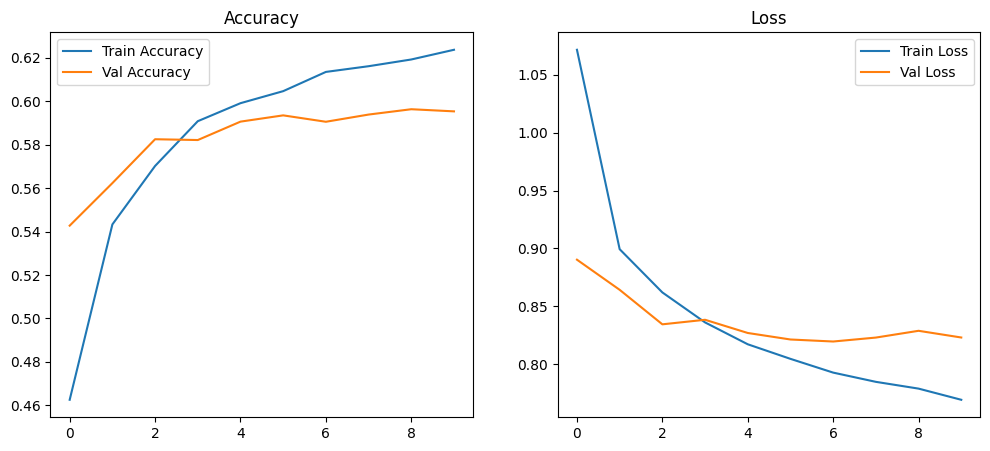

In [77]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [78]:
def predict_sarcasm(text):
    clean = clean_text(text)
    seq = tokenizer.texts_to_sequences([clean])
    pad = pad_sequences(seq, maxlen=max_length, padding="post")
    prediction = model.predict(pad)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])[0]
    return predicted_class

import random

# Randomly select 10 samples from the test set
num_samples = 10
random_indices = random.sample(range(len(df_test)), num_samples)
test_samples = df_test.iloc[random_indices]

# Run predictions
for index, row in test_samples.iterrows():
    text = row['cleaned_tweet']  # Use the original tweet text
    true_label = row['class']  # Actual label
    prediction = predict_sarcasm(text)  # Your prediction function

    print(f"Tweet: {text}")
    print(f"True Label: {true_label}")
    print(f"Predicted: {prediction}")
    print("-" * 50)






1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
Tweet: #whatilearnedtoday as our country burns at least gave us some tunes!
True Label: sarcasm
Predicted: irony
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Tweet: how do and jefry mart each homer and the tigers still lose? thanks dombroski!
True Label: sarcasm
Predicted: sarcasm
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Tweet: thanks for your previous stats #9 in nl scoring coupled with a better staff could be a playoff team fire price
True Label: figurative
Predicted: sarcasm
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Tweet: trump says high ceo pay is a joke 'disgraceful' #gop #tcot #tlot #ccot #tpot #liberty #pjnet #politics #teaparty
True Label: regular
Predicted: regular
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Tweet: the weekend #morning #late #work #beard #l

In [ ]:
print(df_train['class'].value_counts(normalize=True))

class
figurative    0.260883
irony         0.256658
sarcasm       0.254041
regular       0.228417
Name: proportion, dtype: float64


In [79]:
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_padded, test_labels)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3472 - loss: 0.9411

Test Accuracy: 0.6019
Test Loss: 0.8125
